In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow.keras as keras
from tqdm import tqdm
from google.colab import drive
import os
import cv2
import pickle
import json
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score

In [2]:
for module in np, pd, mpl, sklearn, tf, keras:
  print (module.__name__, module.__version__)

numpy 1.18.5
pandas 1.0.4
matplotlib 3.2.1
sklearn 0.22.2.post1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
path = "/content/drive/My Drive"
os.chdir(path)
os.listdir(path)

['Getting started.pdf',
 'daibingze-cv-new.pdf',
 'Colab Notebooks',
 'plant-pathology-2020-fgvc7',
 'VGG_history.pkl',
 'VGG_history_aug.pkl',
 'submissiongooglef.csv',
 'submission.csv',
 'submissionresf.csv',
 'submissionresnof.csv',
 'submissiongooglenof.csv',
 'submission_SVM.csv',
 'GraySVM.ipynb',
 'submission_HOGSVM.csv',
 'Project teams.xlsx',
 'Pythorch_try_1.ipynb',
 'HOGSVM.ipynb']

In [0]:
submission=pd.read_csv('/content/drive/My Drive/plant-pathology-2020-fgvc7/sample_submission.csv')
train=pd.read_csv('/content/drive/My Drive/plant-pathology-2020-fgvc7/train.csv')
test=pd.read_csv('/content/drive/My Drive/plant-pathology-2020-fgvc7/test.csv')

In [6]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [7]:
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [8]:
# Load training set
train_img=[]
train_label=[]
path='/content/drive/My Drive/plant-pathology-2020-fgvc7/images'
for im in tqdm(train['image_id']):
    im=im+".jpg"
    final_path=os.path.join(path,im)
    img=cv2.imread(final_path)
    #img=img.resize((224,224))
    img=cv2.resize(img,(224,224))
    img=img.astype('float32')
    train_img.append(img)
test_img=[]
path='/content/drive/My Drive/plant-pathology-2020-fgvc7/images'
for im in tqdm(test['image_id']):
    im=im+".jpg"
    final_path=os.path.join(path,im)
    img=cv2.imread(final_path)
    img=cv2.resize(img,(224,224))
    img=img.astype(('float32'))
    test_img.append(img)

100%|██████████| 1821/1821 [23:08<00:00,  1.31it/s]


In [0]:
train_label=train.loc[:,'healthy':'scab']

In [10]:
train_label=train.loc[:,'healthy':'scab']
train_img=np.array(train_img)
test_img=np.array(test_img)
train_label=np.array(train_label)

print(train_label)

print("Training set size:",train_img.shape)
print("Training label size:",train_label.shape)

[[0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 ...
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Training set size: (1821, 224, 224, 3)
Training label size: (1821, 4)


(1821, 224, 224, 3)
(1821, 4)


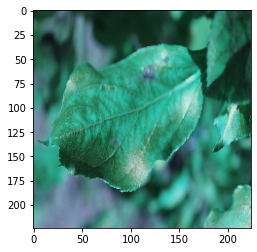

In [11]:
print(train_img.shape)

print(train_label.shape)
from PIL import Image
dataset=train_img
datashow = Image.fromarray(dataset[0,:,:,:].astype('uint8')).convert('RGB')

plt.imshow(datashow)

(1821, 224, 224)


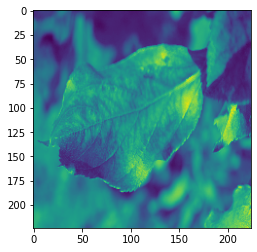

In [12]:
#img_length = 224
data_gray = [color.rgb2gray(i) for i in dataset]

plt.imshow(data_gray[0])
print(np.shape(data_gray))


In [0]:
ppc = 16
hog_images = []
hog_features = []
for image in data_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4,4),block_norm='L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)
# for i in range(0,1820):
#     fd,hog_image = hog(data_gray[i],orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4,4),block_norm='L2',visualize=True)
#     hog_images.append(hog_image)
#     hog_features.append(fd)

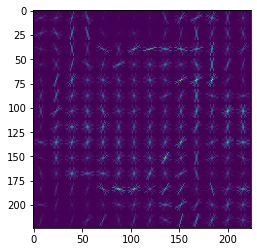

In [14]:
plt.imshow(hog_images[0])

In [0]:
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

In [0]:
train_label=train.loc[:,'healthy':'scab']
train_label=np.array(train_label)

In [17]:
##change label here
train_label = [np.argmax(one_hot)for one_hot in train_label]
train_label=np.array(train_label)
train_label=train_label.reshape(1821,1)
print(train_label.shape)

(1821, 1)


In [31]:
C=100.0
# clf = svm.SVC(kernel='poly', degree=3, gamma='auto', C=C)
clf = svm.LinearSVC(C=C)
hog_features = np.array(hog_features)
data_frame = np.hstack((hog_features,train_label))
np.random.shuffle(data_frame)
print(hog_features.shape)
print(data_frame.shape)
print(train_label.shape)

(1821, 15488)
(1821, 15489)
(1821, 1)


In [0]:
testset=test_img
testshow = Image.fromarray(testset[0,:,:,:].astype('uint8')).convert('RGB')
test_gray = [color.rgb2gray(i) for i in testset]
ppc = 16
thog_images = []
thog_features = []
for timage in test_gray:
    tfd,thog_image = hog(timage, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4,4),block_norm='L2',visualize=True)
    thog_images.append(thog_image)
    thog_features.append(tfd)
    

In [0]:
thog_features=np.array(thog_features)

In [0]:
#What percentage of data you want to keep for training
# percentage = 80
# partition = int(len(hog_features)*percentage/100)

In [34]:
# x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]#data
# y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()#label

x_train, x_test = data_frame[:,:-1], thog_features[:,:]#data
y_train = data_frame[:,-1:].ravel()#label

clf.fit(x_train,y_train)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
# dec = clf.decision_function([[1]])
# dec.shape[1]

In [35]:
y_pred = clf.predict(x_test)
print(y_pred[100:200])
print(y_pred.shape)

[2. 2. 0. 0. 3. 2. 2. 0. 3. 2. 2. 2. 3. 2. 0. 2. 2. 0. 2. 0. 0. 3. 0. 2.
 0. 2. 0. 0. 2. 0. 3. 0. 0. 0. 3. 0. 3. 2. 0. 2. 0. 3. 3. 2. 0. 3. 2. 3.
 2. 0. 0. 0. 1. 3. 0. 2. 0. 3. 3. 2. 2. 3. 2. 3. 2. 3. 3. 0. 2. 2. 3. 2.
 2. 3. 2. 0. 0. 3. 3. 0. 3. 0. 0. 3. 3. 0. 2. 0. 3. 3. 3. 2. 3. 0. 3. 0.
 0. 3. 0. 3.]
(1821,)


In [36]:
from sklearn.preprocessing import OneHotEncoder
output = y_pred # change to actual output
enc = OneHotEncoder()
enc.fit(output.reshape(-1,1))
output_onehot = enc.transform(output.reshape(-1,1)).toarray()
output_onehot
#submission.shape




array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [27]:
submission.loc[:,'healthy':'scab'] = output_onehot
submission.to_csv('submission_HOGSVM.csv',index = False)

ValueError: ignored

In [28]:
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

NameError: ignored